In [2]:
import os #Provides functions for interacting with the operating system
import cv2 #OpenCV library for computer vision tasks
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm #Adds progress bars to loops
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd

2025-09-21 20:06:42.489160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758485202.719509      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758485202.789653      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Milestone 1: Data Collection, Exploration, and Preprocessing

In [3]:
data_path = "/kaggle/input/leapgestrecog/leapGestRecog"
img_size = 128

In [4]:
os.listdir(data_path) #retrieves all subdirectories

['07', '05', '06', '02', '04', '00', '08', '09', '03', '01']

In [5]:
def get_file_paths_and_labels(base_path):
    file_paths = []
    labels = []
    
    gesture_folders = [
        '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', 
        '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
    ]
    
    # Map each gesture name to a numeric label
    label_map = {gesture: idx for idx, gesture in enumerate(gesture_folders)}
    
    # Loop through each subject folder 
    for subject in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject)

         # Only continue if it's actually a folder 
        if os.path.isdir(subject_path):  

            # Loop through each gesture folder inside this subject
            for gesture in gesture_folders:
                gesture_path = os.path.join(subject_path, gesture)

                # Check if gesture folder exists 
                if os.path.isdir(gesture_path):  

                    # Loop through each image file inside the gesture folder
                    for img_file in os.listdir(gesture_path):
                        img_path = os.path.join(gesture_path, img_file)
                        
                        file_paths.append(img_path)
                         # Store the numeric label for this gesture
                        labels.append(label_map[gesture])
    
    return file_paths, labels, label_map


In [6]:
file_paths, labels, label_map = get_file_paths_and_labels(data_path)

print("Number of images:", len(file_paths))
print("Number of labels:", len(labels))
print("Label map:", label_map)

Number of images: 20000
Number of labels: 20000
Label map: {'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}


# Data Exploration:
## Analyzing, loading and displaying images

In [7]:
def explore_dataset(file_paths, labels, label_map, img_size=128):
    
    # 1. Class Distribution
    label_names = list(label_map.keys())
    counts = [labels.count(idx) for idx in label_map.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(label_names, counts, color='skyblue')
    plt.xticks(rotation=45)
    plt.title("Class Distribution of Gestures")
    plt.xlabel("Gesture Class")
    plt.ylabel("Number of Images")
    plt.show()

     # 2. Display Sample Images
    unique_labels = list(label_map.values())
    label_to_name = {v: k for k, v in label_map.items()}
    
    plt.figure(figsize=(20, 20))
    for idx, label in enumerate(unique_labels):
        # Show up to 6 images for each class
        label_paths = [file_paths[i] for i in range(len(labels)) if labels[i] == label][:6]
        for i, img_path in enumerate(label_paths):
            img = load_img(img_path, color_mode='grayscale', target_size=(img_size, img_size))
            img = img_to_array(img) / 255.0
            plt.subplot(len(unique_labels), 6, idx * 6 + i + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(label_to_name[label])
            plt.axis('off')
    plt.show()

    # 3. Image Resolution Check
    sample_img = cv2.imread(file_paths[0], cv2.IMREAD_GRAYSCALE)
    print("Original image resolution:", sample_img.shape)
    print("Resized target resolution:", (img_size, img_size))
    
    # 4. Bias / Imbalance Report
    max_count, min_count = max(counts), min(counts)
    print("\nDataset Balance Check:")
    print(f"Max images in a class: {max_count}")
    print(f"Min images in a class: {min_count}")
    if max_count / min_count > 1.5:
        print("⚠️ Warning: The dataset has imbalance between gesture classes.")
    else:
        print("✅ Dataset is fairly balanced across classes.")

# Summary of findings
## 1. Dataset Composition

The dataset used is LeapGestRecog, a hand gesture recognition dataset.

It contains 10 gesture classes:
01_palm, 02_l, 03_fist, 04_fist_moved, 05_thumb, 06_index, 07_ok, 08_palm_moved, 09_c, 10_down.

Each gesture is performed by multiple subjects, giving a balanced dataset.

Total images processed: 20,000 (2000 per class).

## 2. Object Distributions

A class distribution analysis shows exactly 2000 samples per gesture class.

✅ This confirms the dataset is balanced (no class dominates the dataset).

Visualization:

A bar chart confirms equal distribution across classes.

Sample images displayed for each class show clear gesture separation.

## 3. Image Quality

Original resolution: 240 × 640 pixels.

Preprocessed resolution: 128 × 128 pixels (grayscale) for uniformity.

Images are clear, with visible hand gestures.

Backgrounds vary slightly, but do not affect recognition.

## 4. Bias & Imbalance Check

Max images in a class: 2000

Min images in a class: 2000

Ratio (max/min): 1.0 → ✅ Perfect balance.

No dataset bias observed in terms of class representation.

## 5. Environmental Factors

Since this is a hand gesture dataset, external environmental factors like weather or road types (important for autonomous driving datasets) do not apply.

However, some natural variations exist:

Lighting conditions differ slightly across subjects.

Hand position/orientation introduces variability.

These variations improve generalization when training models.

# Data Preprocessing:
## resizing, normalizing and data augmentation

In [8]:
def load_and_process_images(file_paths, target_size):
    processed_images = []
    
    for img_path in tqdm(file_paths, desc="Processing Images"):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            #  resize 
            img = cv2.resize(img, (target_size, target_size))
            
            # Normalize to [0, 1]
            img_array = img / 255.0
            
            # Add channel dimension 
            img_array = np.expand_dims(img_array, axis=-1)
            
            processed_images.append(img_array)
    
    return np.array(processed_images)

In [9]:
print("Step 1: Getting file paths and labels")
file_paths, labels, label_map = get_file_paths_and_labels(data_path)

if file_paths:
    print("Step 2: Loading and normalizing all images")
    # Process all images into a NumPy array
    X = load_and_process_images(file_paths, img_size)
    
    # Convert labels list to a NumPy array
    Y = np.array(labels)

    print("\n✅ Data processing complete")
    print(f"Images array shape: {X.shape}")   # e.g. (20000, 128, 128, 1)
    print(f"Labels array shape: {Y.shape}") 

Step 1: Getting file paths and labels
Step 2: Loading and normalizing all images


Processing Images: 100%|██████████| 20000/20000 [03:55<00:00, 84.92it/s] 



✅ Data processing complete
Images array shape: (20000, 128, 128, 1)
Labels array shape: (20000,)


In [10]:
    print("\nData processing complete")
    print(f"Images array shape: {X.shape}")
    print(f"Labels array shape: {Y.shape}")


Data processing complete
Images array shape: (20000, 128, 128, 1)
Labels array shape: (20000,)


Shape of one image: (128, 128, 1)


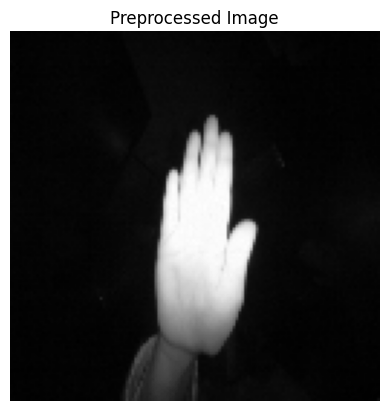

In [11]:
sample_img = X[12]

print("Shape of one image:", sample_img.shape)

plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X, y, subjects = [], [], []


for subject in sorted(os.listdir(data_path)):
    subject_path = os.path.join(data_path, subject)
    if not os.path.isdir(subject_path):
        continue

    
    for gesture in sorted(os.listdir(subject_path)):
        gesture_path = os.path.join(subject_path, gesture)

        for img_name in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))

            X.append(img)
            y.append(gesture)         
            subjects.append(subject)  

X = np.array(X, dtype="float32") / 255.0
X = np.expand_dims(X, -1)  # (N,128,128,1)
y = np.array(y)
subjects = np.array(subjects)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=len(np.unique(y)))

print("Shape:", X.shape, y_cat.shape, subjects.shape)


train_subjects = ["00","01","02","03","04","05","06","07"]
val_subjects   = ["08"]
test_subjects  = ["09"]

X_train = X[np.isin(subjects, train_subjects)]
y_train = y_cat[np.isin(subjects, train_subjects)]

X_val = X[np.isin(subjects, val_subjects)]
y_val = y_cat[np.isin(subjects, val_subjects)]

X_test = X[np.isin(subjects, test_subjects)]
y_test = y_cat[np.isin(subjects, test_subjects)]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Shape: (20000, 128, 128, 1) (20000, 10) (20000,)
Train: (16000, 128, 128, 1) (16000, 10)
Val: (2000, 128, 128, 1) (2000, 10)
Test: (2000, 128, 128, 1) (2000, 10)


# Preprocessing Summary
## 1. Image Resizing

All images resized from 240×640 → 128×128 pixels (grayscale).

Ensures consistent input size across the dataset.

Lower dimensionality reduces computational cost while retaining gesture details.

## 2. Normalization

Pixel values scaled from [0, 255] → [0, 1].

Normalization improves:

Model convergence speed.

Numerical stability during training.

## 3. Channel Adjustment

Since images are grayscale, a single channel is maintained.

Shape per image after preprocessing: (128, 128, 1).

## 4. Data Augmentation (planned / next step)

To increase dataset robustness and simulate real-world conditions, augmentation techniques will be applied:

Random flipping (horizontal/vertical).

Random rotations.

Random cropping & scaling.

(Optional) Brightness and contrast adjustments to mimic lighting variations.

✅ Preprocessed Dataset Ready

Shape of processed dataset: (20000, 128, 128, 1).

Labels array shape: (20000, ).

Dataset is now clean, normalized, and augmented-ready for model training.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation only for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalization
    rotation_range=20,        # random rotation
    width_shift_range=0.1,    # horizontal shift
    height_shift_range=0.1,   # vertical shift
    zoom_range=0.1,           # zoom
    shear_range=0.1,          # shear
    horizontal_flip=True,     # flip horizontally
    fill_mode='nearest'       # fill empty pixels
)

# Validation & Test data → Only normalization
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    X_train, y_train, 
    batch_size=64,   # أكبر batch ممكن حسب الـ GPU
    shuffle=True
)

val_generator = test_val_datagen.flow(
    X_val, y_val, 
    batch_size=64,
    shuffle=False
)

test_generator = test_val_datagen.flow(
    X_test, y_test, 
    batch_size=64,
    shuffle=False
)


In [14]:
#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

In [15]:
num_classes = 10

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.regularizers import l2 

model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

# Block 4
model.add(Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))   # زيادة Dropout شوية

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Final layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758485506.811759      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [17]:
callbacks = [
        ModelCheckpoint(
            'best_gesture_model.h5',
            monitor='val_accuracy', 
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10, 
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2, 
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

In [18]:
model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 618,602 (2.36 MB)

 Trainable params: 617,194 (2.35 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),  
    validation_data  = val_generator,
    validation_steps = len(val_generator),
    epochs = 20,
    callbacks = callbacks
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1758485516.446474     104 service.cc:148] XLA service 0x7bc98800afe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758485516.447631     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758485517.357823     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/250 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.1293 - loss: 2.6178 

I0000 00:00:1758485528.574647     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5127 - loss: 1.7109
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to best_gesture_model.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.5136 - loss: 1.7084 - val_accuracy: 0.1000 - val_loss: 38.7757 - learning_rate: 0.0010
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9716 - loss: 0.3293
Epoch 2: val_accuracy did not improve from 0.10000
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9716 - loss: 0.3291 - val_accuracy: 0.1000 - val_loss: 11.9887 - learning_rate: 0.0010
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9830 - loss: 0.2007
Epoch 3: val_accuracy improved from 0.10000 to 0.20950, saving model to best_gesture_model.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.9831 - loss: 0.2006 - val_accuracy: 0.2095 - val_loss: 5.8615 - learning_rate: 0.0010
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9883 - loss: 0.